In [19]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from glob import glob
import os

# Read Data

In [20]:
# Define the relative path pattern for .edf files in all subdirectories of the Data directory
path_pattern = os.path.join('..', '..', 'Data', 'Subj*', '*.edf')

# Use glob to get all matching files
edf_files = glob(path_pattern, recursive=True)

# Remove all files that contain .md in it
edf_files = [f for f in edf_files if '.md' not in f]

In [21]:
# Creating recording metadata dataframe: subject_id, pace, file_path
recording_metadata = []
for file in edf_files:
    # Extract the subject_id and pace from the file path
    subject_id = int(file.split(os.sep)[-2].split('Subj')[-1])
    pace = file.split(os.sep)[-1].split('_')[1]
    recording_metadata.append([subject_id, pace, file])

In [29]:
md = pd.DataFrame(recording_metadata, columns=['subject_id', 'pace', 'file_path'])
md.to_csv('recording_metadata.csv', index=False)

In [23]:
def get_stimulus_recording(path):
    raw_edf = mne.io.read_raw_edf(path, preload=True, verbose=False)
    with(open(path.replace('edf', 'json'))) as f:
        data_json = json.load(f)
    # Get recording start time
    recording_start_time = pd.to_datetime(data_json['Markers'][0]['startDatetime'])

    # Get start time from data_json with phase_name = 'instructions_task'
    starttime_data = pd.to_datetime(data_json['Markers'][10]['endDatetime'])
    endtime_data = pd.to_datetime(data_json['Markers'][11]['startDatetime'])

    # Relative start time
    relative_start_time = (starttime_data - recording_start_time).total_seconds()
    relative_end_time = (endtime_data - recording_start_time).total_seconds()
    
    r = raw_edf.copy().crop(tmin=relative_start_time, tmax=relative_end_time)
    
    # Floor r duration to 600 seconds
    r_duration = r.times[-1]
    if r_duration > 600:
        r.crop(tmin=0, tmax=600)
    
    return r

In [24]:
def read_and_get_data(path):
    recording = get_stimulus_recording(path)
    
    # Select Channels in standard 10-20 format that EPOC X used
    # AF3, AF4, F3, F4, FC5, FC6, T7, T8, P7, P8, O1, O2
    montage = mne.channels.make_standard_montage('standard_1020')
    recording.drop_channels([ch for ch in recording.ch_names if ch not in montage.ch_names])    
    
    # Setting montage (position of electrodes)
    recording.set_montage('standard_1020')
    
    # Setting EEG reference
    recording.set_eeg_reference('average', verbose = False)
    
    # Bandpass Filter at 1 - 50 Hz
    recording.filter(l_freq = 1, h_freq = 50, verbose=False)
    
    return recording

In [25]:
raws = [read_and_get_data(f) for f in edf_files]
print(len(raws))

32


In [40]:
raw_data_test = raws[0].get_data()

# Creating Epochs

In [26]:
# Creating epochs of 2 seconds with 50% overlap
duration = 2
overlap = duration / 2
epochs = [mne.make_fixed_length_epochs(r, duration=duration, overlap=overlap, preload=True, verbose=False) for r in raws]

# Data Cleaning

In [27]:
# Autoreject
from autoreject import AutoReject

n_interpolate = [2, 3, 4]
ar = AutoReject(n_interpolate=n_interpolate, verbose=False, random_state=42)

epochs_ar = []
reject_log = []
for epoch in epochs:
    ar.fit(epoch)
    e, r = ar.transform(epoch, return_log = True)
    epochs_ar.append(e)
    reject_log.append(r)

Dropped 44 epochs: 0, 1, 2, 3, 4, 5, 79, 80, 81, 82, 83, 99, 104, 108, 109, 120, 180, 181, 191, 274, 275, 276, 298, 299, 314, 315, 316, 317, 400, 401, 402, 403, 440, 441, 442, 443, 454, 459, 463, 536, 543, 546, 547, 562
Dropped 136 epochs: 0, 1, 6, 7, 10, 11, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 32, 33, 34, 35, 36, 37, 41, 47, 51, 52, 83, 84, 88, 89, 99, 100, 105, 106, 111, 122, 123, 124, 128, 147, 148, 149, 150, 171, 172, 187, 188, 201, 202, 203, 204, 205, 209, 210, 219, 220, 243, 252, 253, 260, 261, 300, 348, 349, 350, 369, 370, 377, 380, 388, 389, 390, 399, 407, 415, 416, 417, 430, 431, 459, 468, 469, 471, 472, 473, 480, 485, 497, 498, 502, 503, 504, 505, 509, 510, 511, 512, 515, 516, 517, 522, 523, 524, 525, 526, 527, 528, 536, 544, 545, 546, 547, 548, 549, 550, 551, 552, 559, 560, 561, 578, 579, 580, 581, 583, 584, 585, 586, 587, 591, 592, 595, 596, 597
Dropped 135 epochs: 1, 2, 3, 4, 6, 7, 8, 9, 10, 16, 55, 56, 64, 65, 82, 83, 84, 85, 90, 91, 92, 93, 94, 97, 99, 102, 1

In [37]:
import os

# Export epochs_ar
for i, e in enumerate(epochs_ar):
    directory = f"../../CleanedEpochs/Recording/Subj{md['subject_id'][i]}/"
    filename = f"{directory}{md['pace'][i]}-epo.fif"
    
    # Create the directory if it doesn't exist
    os.makedirs(directory, exist_ok=True)
    
    # Save the epoch
    e.save(filename)

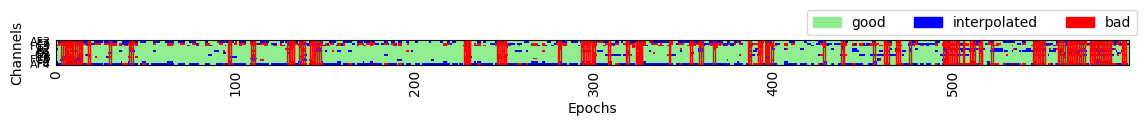

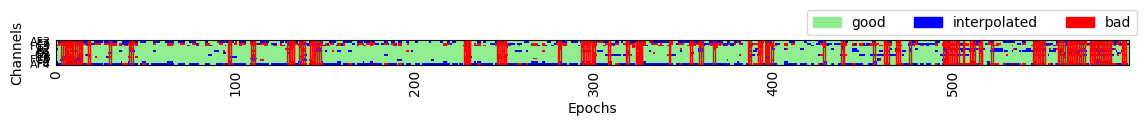

In [36]:
reject_log[-1].plot('horizontal')